# REM Sleep Detection

First importing the libraries and the data.

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})



In [84]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Using the wavelet transform the instantaneous power is computed for both the theta (6-10Hz) and delta (2-4Hz) signal. Note: the two peaks visible in the delta signal have been cut off and would be so high (around 6e6 a.u.) that if they would be displayed completely the plot would become unclear.

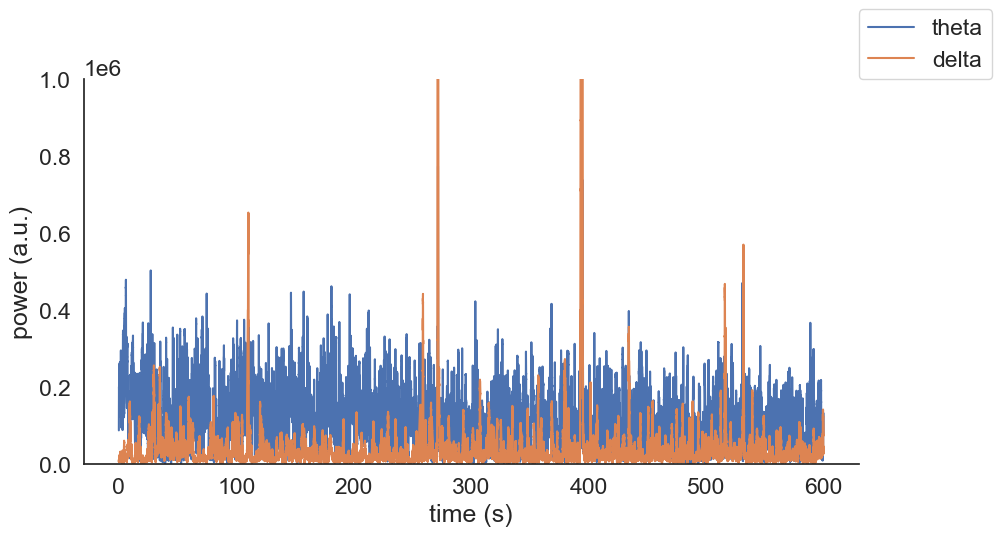

In [151]:
from pywt import scale2frequency
from pywt import cwt
from pywt import wavelist

start = 0 #in seconds
end = 600 # in seconds

sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig) # get rid of 0 frequency component

#Theta signal
frequencies_th =  np.linspace(6,10,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales_th = scale2frequency(wavelet, frequencies_th)
cwtmatr_th, _ = cwt(sig, wavelet=wavelet, scales=scales_th,
                  sampling_period=1.0/sampling_rate)

power_th = np.mean(abs(cwtmatr_th)**2,axis=0)

#Delta signal
frequencies_del =  np.linspace(2,4,50)/sampling_rate
wavelet = 'cmor1.0-1.0'
scales_del = scale2frequency(wavelet, frequencies_del)
cwtmatr_del, _ = cwt(sig, wavelet=wavelet, scales=scales_del,
                  sampling_period=1.0/sampling_rate)

power_del = np.mean(abs(cwtmatr_del)**2,axis=0)


plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(power_th)),power_th, label = 'theta')
plt.plot(np.linspace(start,end,len(power_del)),power_del, label = 'delta')
plt.ylim(0, 1e6)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.legend(loc=(1,1))

Using scipy.stats.zscore to the two signals. The zscore is plotted below.

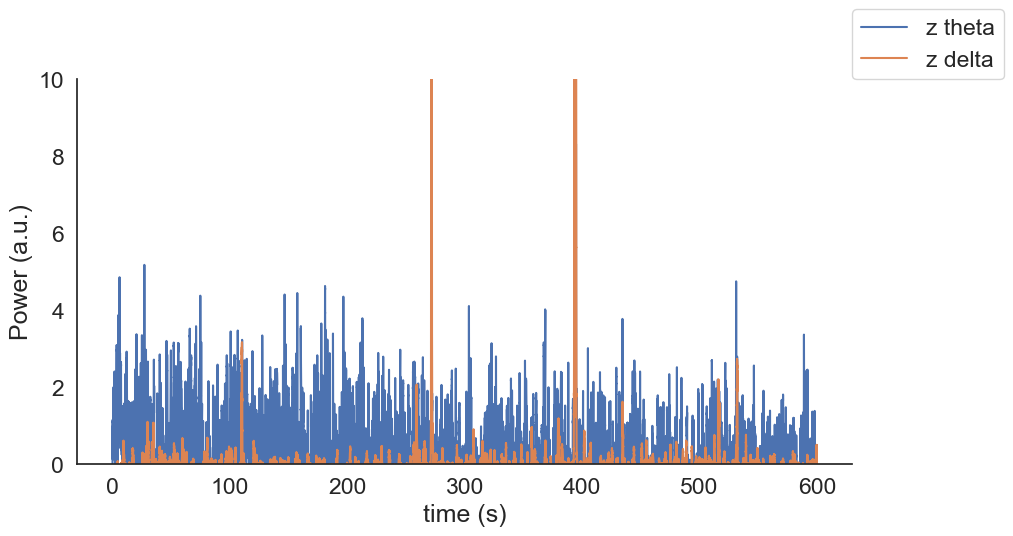

In [91]:
from scipy.stats import zscore

ztheta = zscore(power_th)
zdelta = zscore(power_del)

plt.figure(figsize = (10,5))
plt.plot(np.linspace(start,end,len(power_th)),ztheta, label = 'z theta')
plt.plot(np.linspace(start,end,len(power_del)),zdelta, label = 'z delta')
plt.ylim(0,10)
plt.xlabel('time (s)')
plt.ylabel('Power (a.u.)') 
plt.legend(loc=(1,1))


Plotting the difference between the theta and delta signal (absolute value). The line corresponding to 0.2e6 a.u. is also plotted. Periods with power values above this line correspond to REM signals, below the line correspond to non REM signals.  

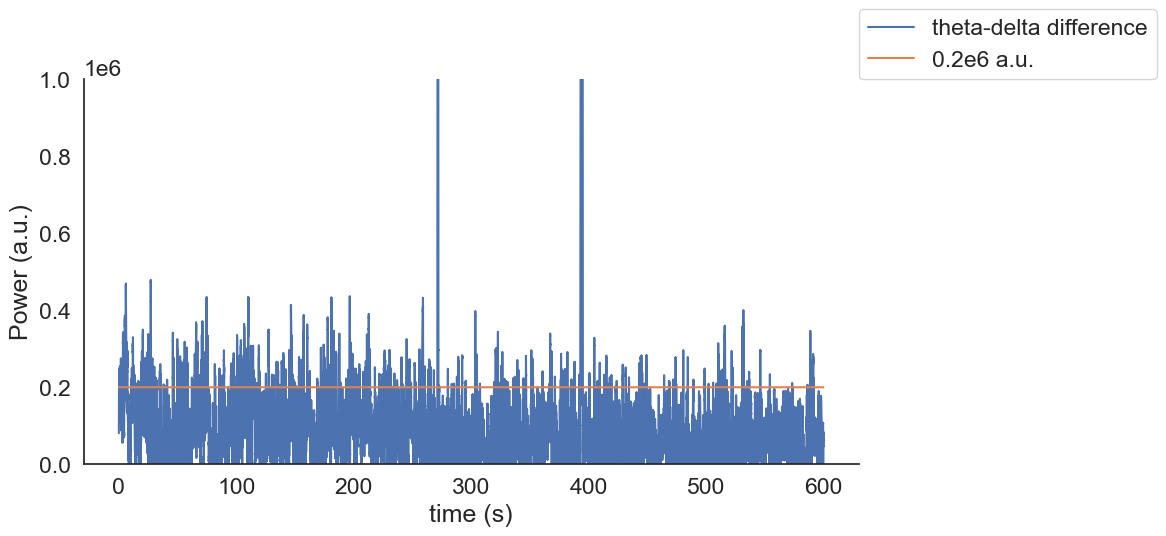

In [103]:
plt.figure(figsize = (10,5))
plt.plot(np.linspace(start,end,len(power_th)),abs(power_th-power_del), label = 'theta-delta difference')
plt.plot(np.linspace(start,end,len(power_th)), 0.2e6 * np.ones(np.size(np.linspace(start,end,len(power_th)))), label = '0.2e6 a.u.')
plt.ylim(0,1e6)

plt.xlabel('time (s)')
plt.ylabel('Power (a.u.)') 
plt.legend(loc=(1,1))

REM and nREM contain the timestamps for REM sleep and non REM sleep respectively.

In [156]:
REM = np.where(abs(power_th-power_del) > 0.2e6)
nREM = np.where(abs(power_th-power_del) < 0.2e6)

print('Number of timestamps for REM sleep:', np.size(REM[0]))
print('Number of timestamps for nREM sleep:', np.size(nREM[0]))

Number of timestamps for REM sleep: 57858
Number of timestamps for nREM sleep: 542142


Plotting the change in thershold:

In [141]:
REMvalues = np.array([])
for i in range(10):
    REM = abs(power_th-power_del) > (0.05+0.05*i)*10**6
    REMwhere = np.where(REM)
    REMsize = np.size(REMwhere[0])
    REMvalues = np.append(REMvalues, REMsize)


Text(0, 0.5, 'Number of Timestamps')

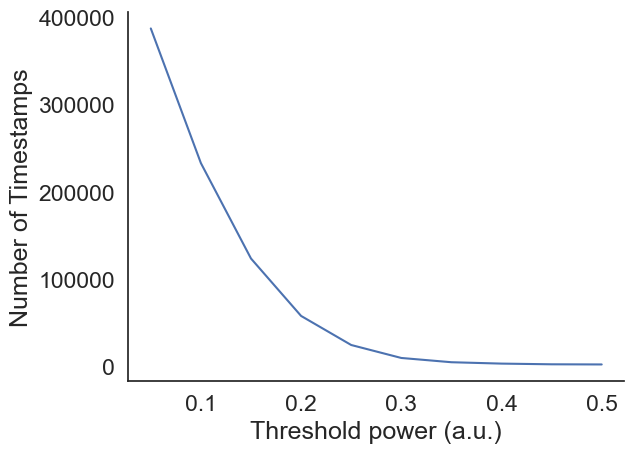

In [149]:
plt.plot([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5],REMvalues)
plt.xlabel('Threshold power (a.u.)')
plt.ylabel('Number of Timestamps')

Changing the thershold with which REM sleep is defined (value of 0.2e12) obviously has consequences for the ammount of REM sleep (timestamps) observed. Lowering this threshold will increase the ammount of REM sleep observed and increasing the treshold will decrease the ammount of REM sleep (timestamps). The total number of timestamps in the data is 600000.